In [220]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import pandas as pd
from glob import glob
import os


In [221]:
params = {
    'LR' : 1e-3,
    'kernel_size' : 3,
    'filters' : 16,
    'batch' : 16,
    'strides' : 1,
    'dropout_rate' : 0.5
}
data_path = "final_results_sims_steps/sims"

In [222]:
class CombinedArrayDataset(Dataset):
    def __init__(self, folder_path):
        csv_files = glob(os.path.join(folder_path, "*.csv"))
        data_frames = [pd.read_csv(file) for file in csv_files]
        combined_df = pd.concat(data_frames, ignore_index=True)

        self.belief = combined_df['belief'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.ship = combined_df['ship'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.labels = combined_df['remain'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        belief = self.belief[idx]
        ship = self.ship[idx]
        label = self.labels[idx]

        belief = torch.tensor(belief, dtype=torch.float32) 
        ship = torch.tensor(ship, dtype= torch.float32)
        label = torch.tensor(label, dtype=torch.float32) 
        input_tensor = torch.stack((belief, ship), dim=0) 
        return input_tensor, label

dataset = CombinedArrayDataset(data_path)


In [223]:
len(dataset)

132462

In [224]:
input, label = dataset[0]
input.shape, label

(torch.Size([2, 30, 30]), tensor(178.))

In [225]:
input

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0000],
         [0.0000, 0.0018, 0.0000,  ..., 0.0018, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0018, 0.0018,  ..., 0.0018, 0.0018, 0.0000],
         [0.0000, 0.0000, 0.0018,  ..., 0.0000, 0.0018, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         [0.0000, 1.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [226]:
class SpaceRatNetwork(nn.Module):
    def __init__(self, filters, kernel_size, strides, dropout_rate):
        super(SpaceRatNetwork, self).__init__()
        self.conv1 = nn.Conv2d(2, filters, kernel_size, stride=strides, padding = 1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
        conv_out_size = ((30 - kernel_size + 2) // strides) + 1  
        pool_out_size = ((conv_out_size - 2) // 2) + 1  
        fc1_input_size = filters * (pool_out_size ** 2) 
        
        self.fc1 = nn.Linear(fc1_input_size, 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,1)
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [227]:

device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
print(f"using device: {device}")

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=params['batch'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params['batch'], shuffle=False)

using device: mps


In [228]:
model = SpaceRatNetwork(params['filters'], params['kernel_size'],params['strides'] ,params['dropout_rate']).to(device)
loss_funtion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['LR'])

In [229]:
model.train()
train_losses = []
test_losses = []

In [230]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = loss_funtion(outputs.squeeze(), targets)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Testing Loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():  
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_funtion(outputs.squeeze(), targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Test Loss: {avg_test_loss:.4f}")

/Users/christomathew/PycharmProjects/ML_spacerat/mlrat_venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Train Loss: 2137.3076
Test Loss: 1539.3951
Epoch 2/50, Train Loss: 1749.7117
Test Loss: 1528.6503
Epoch 3/50, Train Loss: 1667.7715
Test Loss: 1489.8882
Epoch 4/50, Train Loss: 1599.7826
Test Loss: 1504.7917
Epoch 5/50, Train Loss: 1549.9892
Test Loss: 1385.0849
Epoch 6/50, Train Loss: 1514.5216
Test Loss: 1346.6282
Epoch 7/50, Train Loss: 1477.4362
Test Loss: 1331.7640
Epoch 8/50, Train Loss: 1445.3661
Test Loss: 1294.7926
Epoch 9/50, Train Loss: 1415.8689
Test Loss: 1273.7537
Epoch 10/50, Train Loss: 1399.1899
Test Loss: 1248.5919
Epoch 11/50, Train Loss: 1369.7277
Test Loss: 1217.5159
Epoch 12/50, Train Loss: 1350.8730
Test Loss: 1183.3951
Epoch 13/50, Train Loss: 1333.5934
Test Loss: 1173.7955
Epoch 14/50, Train Loss: 1310.9460
Test Loss: 1162.8276
Epoch 15/50, Train Loss: 1287.7903
Test Loss: 1128.3571
Epoch 16/50, Train Loss: 1278.6543
Test Loss: 1088.0315
Epoch 17/50, Train Loss: 1258.4903
Test Loss: 1082.8993
Epoch 18/50, Train Loss: 1253.4889
Test Loss: 1103.0627
E

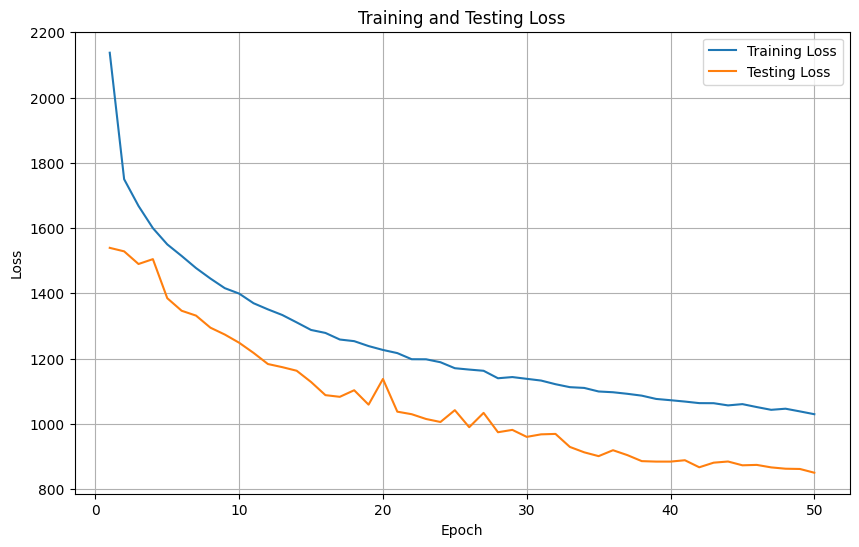

In [233]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

In [236]:
# Save the trained model's state dictionary
torch.save(model.state_dict(), 'model_float.pth')
print("Model saved successfully.")

Model saved successfully.


In [237]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Size: {param.size()}, Total Elements: {param.numel()}")

Parameter: conv1.weight, Size: torch.Size([16, 2, 3, 3]), Total Elements: 288
Parameter: conv1.bias, Size: torch.Size([16]), Total Elements: 16
Parameter: fc1.weight, Size: torch.Size([256, 3600]), Total Elements: 921600
Parameter: fc1.bias, Size: torch.Size([256]), Total Elements: 256
Parameter: fc2.weight, Size: torch.Size([128, 256]), Total Elements: 32768
Parameter: fc2.bias, Size: torch.Size([128]), Total Elements: 128
Parameter: fc3.weight, Size: torch.Size([1, 128]), Total Elements: 128
Parameter: fc3.bias, Size: torch.Size([1]), Total Elements: 1


### A sample prediction

In [238]:
test_dataset_size = len(test_dataset)

In [239]:
random_index = random.randint(0, test_dataset_size - 1)
test_instance, true_label = test_loader.dataset[random_index]  # Get the data at the index
test_instance, true_label

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 8.9619e-07, 7.9380e-07,  ..., 4.3623e-06,
           9.1242e-07, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9539e-05,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 1.0263e-12, 4.7900e-12,  ..., 3.5003e-18,
           5.6152e-19, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 1.0978e-12,  ..., 0.0000e+00,
           8.7633e-20, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.000

In [240]:
test_instance.shape, true_label

(torch.Size([2, 30, 30]), tensor(106.))

In [241]:
random_index = random.randint(0, test_dataset_size - 1)
test_instance, true_label = test_loader.dataset[random_index]
test_instance = test_instance.unsqueeze(0).to(device) 
true_label = true_label.to(device)

with torch.no_grad():  
    output = model(test_instance) 
    
if isinstance(output, torch.Tensor) and output.ndimension() == 1:
    predicted_class = torch.argmax(output, dim=1) 
    print(f"Predicted class: {predicted_class.item()}")
elif output.ndimension() == 2:  
    predicted_value = output.item()  #
    print(f"Predicted value: {int(predicted_value)}")
else:
    print("Unexpected model output shape.")
print(f"True label: {int(true_label.item())}")

Predicted value: 88
True label: 86
